Ссылка на данные: https://drive.google.com/drive/folders/1Nm1XbW95qb-5AGv4yIvAkCuAQC9CXiOc?usp=sharing

In [ ]:
!gdown 1hB36sReQ0PgOEy1ie0uTs0NHEKY8F1e1
!gdown 1rZLZQfpUsPIh3nMl3GbOfqJDsjhtEG1i

Downloading...
From: https://drive.google.com/uc?id=1hB36sReQ0PgOEy1ie0uTs0NHEKY8F1e1
To: /content/train.csv
100% 241M/241M [00:01<00:00, 124MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rZLZQfpUsPIh3nMl3GbOfqJDsjhtEG1i
To: /content/test.csv
100% 60.1M/60.1M [00:00<00:00, 123MB/s]


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import pandas as pd
from tqdm import tqdm_notebook
import cv2
from IPython.display import clear_output


from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Flatten
import tensorflow as tf
import keras
from keras import backend as K
from sklearn.metrics import accuracy_score, f1_score


from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False


EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
N_CLASSES = len(EMOTIONS)

In [ ]:
# каждое изображение растянуто в строку в таблице
# преобразуем в привычный массив, не создавая папки с изображениями явным образом,
# т.к. метод .fit() работает гораздо быстрее чем .fit_generator()
# для контроля переобучения выделите из X_train, y_train данные для валидации

img_width, img_height = (48,48)

def str_to_image(image_blob):
    image_string = image_blob[0].split(' ')
    image_data = np.asarray(image_string, dtype=np.uint8).reshape(48,48)
    return image_data

def csv_to_array(csv):
    X = csv.pixels.values
    X = np.apply_along_axis(str_to_image, 1, X[:,None])/255.
    X = X[...,None]
    return X

train = pd.read_csv('train.csv') # для обучения и валидации
test = pd.read_csv('test.csv') # для сабмита на кагл

y_train = train.emotion.values
X_train = csv_to_array(train)
X_test= csv_to_array(test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=N_CLASSES)

# X_val, y_val = ... # Ваш код здесь

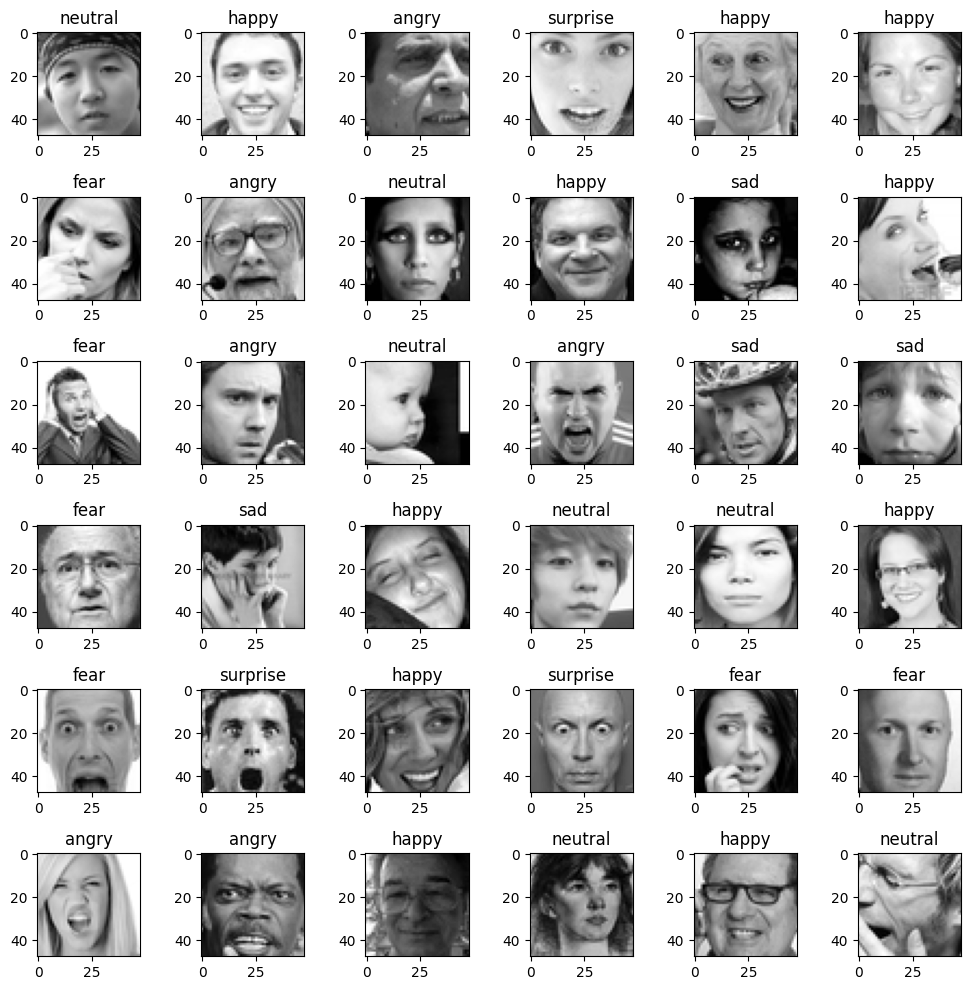

In [ ]:
# посмотрим как выглядят изображения
N_IMAGES_TO_PLOT = 36
fig, axes = plt.subplots(nrows=np.sqrt(N_IMAGES_TO_PLOT).astype(int),
                         ncols = np.sqrt(N_IMAGES_TO_PLOT).astype(int),
                         figsize=(10,10))

rand_indx = np.random.choice(np.arange(N_IMAGES_TO_PLOT), size=N_IMAGES_TO_PLOT, replace=False)
for ax, emotion_index, img in zip(axes.flatten(), train.emotion.values[rand_indx], X_train[rand_indx]):
    img = img[:,:,0] # [48,48,1] -> [48,48]
    ax.imshow(img, cmap='gray')
    emotion = EMOTIONS[emotion_index]
    ax.set_title(emotion)
plt.tight_layout()
plt.show()

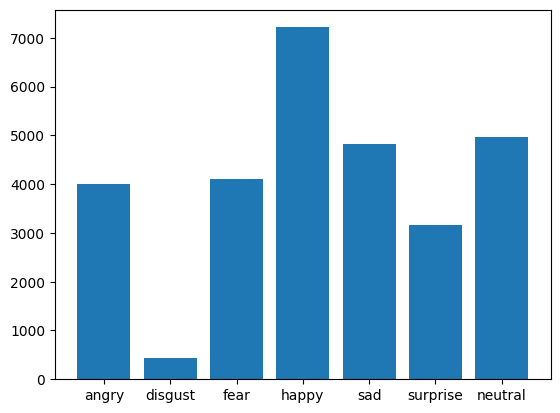

In [ ]:
# посмотрим насколько сбалансированны классы в обучающей выборке
train_count = train.groupby('emotion').count()
plt.bar(x = EMOTIONS,
        height=train_count.values.flatten())
plt.show()

Виден сильный дисбаланс между классом `disguist` и остальными

In [ ]:
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_width, img_height)
else:
    input_shape = (img_width, img_height, 1)

model = Sequential()

model.add(Conv2D(32, (2, 2), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(N_CLASSES))
model.add(Activation('softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

# аугментация
datagen = ImageDataGenerator(width_shift_range=0.05,
                             height_shift_range=0.05,
                             rotation_range=10)
datagen.fit(X_train)
N_EPOCHS = 50
history_cnn = model.fit_generator(datagen.flow(X_train, y_train, batch_size=100),
                                  epochs=N_EPOCHS,
                                  workers = 400,
                                  shuffle = True)

Epoch 1/50


<ipython-input-13-72bcb08106e8>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_cnn = model.fit_generator(datagen.flow(X_train, y_train, batch_size=100),


288/288 [==============================] - 31s 67ms/step - loss: 1.6899 - accuracy: 0.3246
Epoch 2/50
288/288 [==============================] - 17s 56ms/step - loss: 1.4822 - accuracy: 0.4305
Epoch 3/50
288/288 [==============================] - 17s 58ms/step - loss: 1.3796 - accuracy: 0.4731
Epoch 4/50
288/288 [==============================] - 17s 57ms/step - loss: 1.3129 - accuracy: 0.5026
Epoch 5/50
288/288 [==============================] - 17s 57ms/step - loss: 1.2663 - accuracy: 0.5187
Epoch 6/50
288/288 [==============================] - 17s 57ms/step - loss: 1.2267 - accuracy: 0.5333
Epoch 7/50
288/288 [==============================] - 17s 57ms/step - loss: 1.1949 - accuracy: 0.5456
Epoch 8/50
288/288 [==============================] - 17s 58ms/step - loss: 1.1605 - accuracy: 0.5604
Epoch 9/50
288/288 [==============================] - 17s 58ms/step - loss: 1.1379 - accuracy: 0.5705
Epoch 10/50
288/288 [==============================] - 17s 56ms/step - loss: 1.1091 - accurac

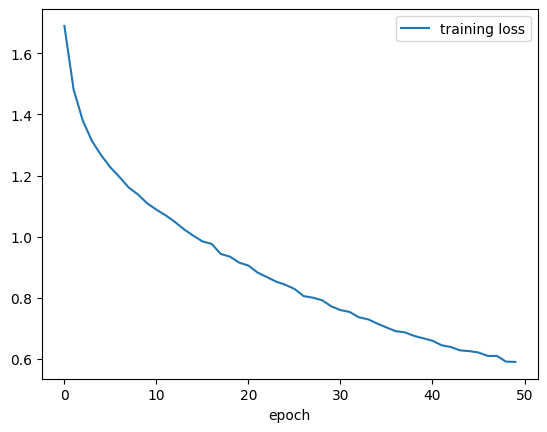

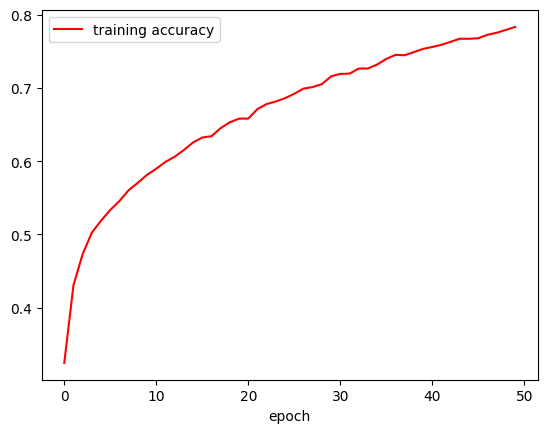

In [ ]:
plt.figure()
plt.plot(history_cnn.history['loss'], label='training loss')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(history_cnn.history['accuracy'], color='r', label='training accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

### Как сделать лучше?

 - Начните со сверточной нейронной сети: Conv2D -> Activation -> ReLU -> Conv2D ... -> Dense
 - Transfer Learning: взять предобученную на большом датасете модель и слегка дообучить ее, подстроив под новую задачу. Это возможно, т.к. большая часть слоев нейронной сети, обученной для классификации изображений, извлекает признаки из изображения, а последний, линейный слой, выступает в роли классификатора. Подробнее о том как это использовать - [здесь](https://neurohive.io/ru/tutorial/transfer-learning-keras/)
 - Аугментация данных: небольшой размер датасета и большое количество параметров модели (что характерно для нейронных сетей) способствует переобучению. Проблему недостатка данных можно решить трансформацией батча на этапе обучения, например, вращая изображения или меняя уровень яркости. Подробнее - [здесь](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/)  
 - Попробуйте убрать дисбаланс в данных, использовав простой oversampling: например для каждого класса добавьте в него случайно выбранные из него-же данные.

In [ ]:
# вычисляет и скачивает файл для submission на kaggle
def submit(model, X_test):

    prediction=model.predict(X_test,  workers=400)

    pred_classes = prediction.argmax(-1)
    df = pd.DataFrame(data = {'Id':np.arange(len(pred_classes)),
                              'Category':pred_classes})

    df.to_csv('submission.csv', index=False)
    files.download('submission.csv')

submit(model, X_test)

225/225 [==============================] - 1s 2ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>